In [1]:
import numpy as np

In [2]:
def solve_simplex(costs):
    from scipy.optimize import linprog

    size = costs.shape[0]
    costs = costs.reshape(size * size)

    result = linprog(
        c=costs,
        A_eq=np.vstack([np.repeat(np.eye(size), size, axis=1),
                        np.hstack(np.repeat([np.eye(size)], size, axis=0))]),
        b_eq=np.ones(size * 2),
    )

    if result.success:
        return result.fun

    return None

In [3]:
def solve_genetic(costs):
    import random
    from deap import base
    from deap import creator
    from deap import tools
    from deap import algorithms

    size = costs.shape[0]

    creator.create('FitnessMin', base.Fitness, weights=[-1.0])
    creator.create('Individual', list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()

    toolbox.register('random_permutation', random.sample, range(size), size)
    toolbox.register('random_individual', tools.initIterate, creator.Individual, toolbox.random_permutation)
    toolbox.register('random_population', tools.initRepeat, list, toolbox.random_individual)

    toolbox.register('evaluate', lambda individual: [sum(costs[a, t] for a, t in enumerate(individual))])
    toolbox.register('mate', tools.cxOrdered)
    toolbox.register('mutate', tools.mutShuffleIndexes, indpb=0.10)
    toolbox.register('select', tools.selTournament, tournsize=3)

    hall_of_fame = tools.HallOfFame(1)

    statistics = tools.Statistics(lambda individual: individual.fitness.values)
    statistics.register('min', np.min)

    population, logbook = algorithms.eaSimple(
        population=toolbox.random_population(n=50),
        toolbox=toolbox,
        cxpb=0.50,
        mutpb=0.20,
        ngen=200,
        stats=statistics,
        halloffame=hall_of_fame,
        verbose=False,
    )

    return min(logbook.select('min'))

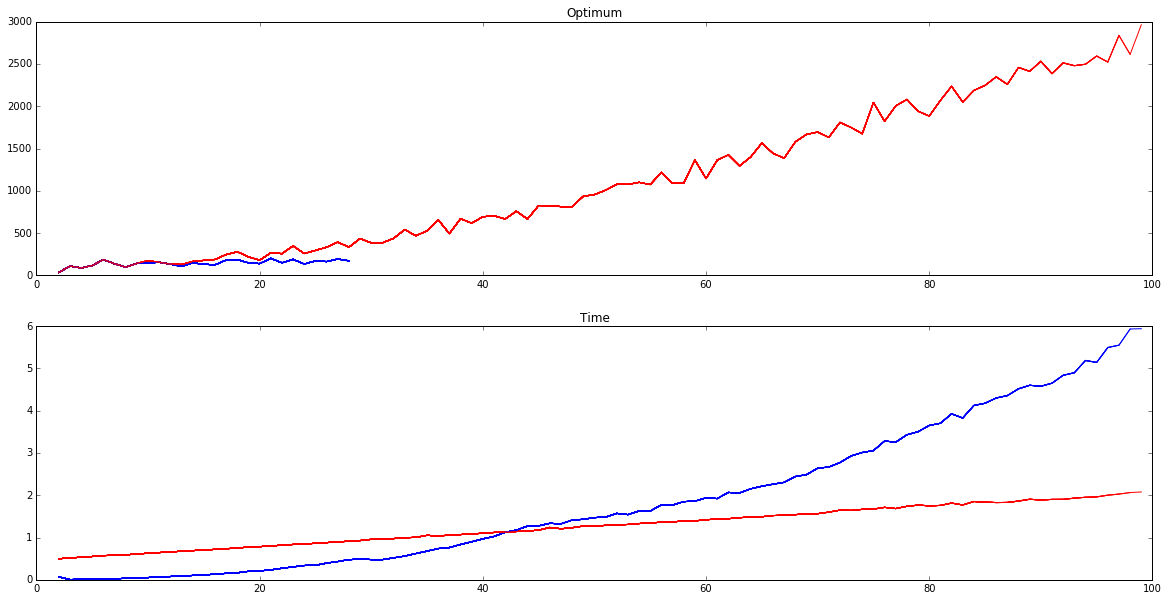

In [4]:
from time import time as get_time

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display

plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1).set_title('Optimum')
plt.subplot(2, 1, 2).set_title('Time')

sizes = []
simplex_values, simplex_times = [], []
genetic_values, genetic_times = [], []
for size in range(2, 100):
    sizes.append(size)
    
    costs = np.ceil(np.random.uniform(0, 100, (size, size)))
    
    simplex_time = get_time()
    simplex_value = solve_simplex(costs)
    simplex_time = get_time() - simplex_time
    simplex_values.append(simplex_value)
    simplex_times.append(simplex_time)
    
    genetic_time = get_time()
    genetic_value = solve_genetic(costs)
    genetic_time = get_time() - genetic_time
    genetic_values.append(genetic_value)
    genetic_times.append(genetic_time)
    
    plt.subplot(2, 1, 1)
    plt.plot(sizes, simplex_values, 'b',
             sizes, genetic_values, 'r')
       
    plt.subplot(2, 1, 2)
    plt.plot(sizes, simplex_times, 'b',
             sizes, genetic_times, 'r')

    display.display(plt.gcf())
    display.clear_output(wait=True)
